In [10]:
import tensorflow as tf
from aeon.datasets import load_classification
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import numpy as np
import time

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load the data from aeon

In [4]:
X_train_f, y_train_f = load_classification(name="KeplerLightCurves", split="train", return_metadata=False)
X_test_f, y_test_f = load_classification(name="KeplerLightCurves", split="test", return_metadata=False)

In [5]:
X_train = X_train_f.squeeze(axis=1)
y_train = y_train_f.astype(int)
X_test = X_test_f.squeeze(axis=1)
y_test = y_test_f.astype(int)

X_train_window = X_train[:, :200]
X_test_window = X_test[:, :200]

In [6]:
class_a_tr_idxs = np.argwhere(y_train == 3).flatten()
x_tr_class_a = X_train_window[class_a_tr_idxs, :]
class_b_tr_idxs = np.argwhere(y_train == 5).flatten()
x_tr_class_b = X_train_window[class_b_tr_idxs, :]
X_train_sub = np.vstack([x_tr_class_a, x_tr_class_b])
y_train_sub = np.concatenate([np.ones(len(class_a_tr_idxs), dtype=np.int8), 2*np.ones(len(class_b_tr_idxs), dtype=np.int8)])

In [7]:
class_a_te_idxs = np.argwhere(y_test == 3).flatten()
x_te_class_a = X_test_window[class_a_te_idxs, :]
class_b_te_idxs = np.argwhere(y_test == 5).flatten()
x_te_class_b = X_test_window[class_b_te_idxs, :]
X_test_sub = np.vstack([x_te_class_a, x_te_class_b])
y_test_sub = np.concatenate([np.ones(len(class_a_te_idxs), dtype=np.int8), 2*np.ones(len(class_b_te_idxs), dtype=np.int8)])

Check the shapes

In [8]:
print(X_train_sub.shape)
print(y_train_sub.shape)
print(X_test_sub.shape)
print(y_test_sub.shape)

(427, 200)
(427,)
(185, 200)
(185,)


Rescale the data

In [9]:
# rescale the data
zs = StandardScaler().fit(X_train_sub)
X_train_sub_zs = zs.transform(X_train_sub)
X_test_sub_zs = zs.transform(X_test_sub)

Train the model

In [ ]:
# 500 epochs per classifier, 5 classifiers in ensemble
classifier = InceptionTimeClassifier(n_epochs=1500, verbose=True)
start = time.perf_counter()
classifier.fit(X_train_sub_zs, y_train_sub)
end = time.perf_counter()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 200, 1)         │              0 │ input_layer[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 32)        │          1,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 32)        │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 32)        │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 32)        │             32 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 200, 128)       │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0],        │
│                           │                        │                │ conv1d_2[0][0],        │
│                           │                        │                │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 200, 128)       │            512 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 200, 128)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 32)        │          4,096 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 200, 128)       │              0 │ activation[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 32)        │         40,960 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 200, 32)        │         20,480 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 200, 32)        │         10,240 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 32)        │          4,096 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 200, 128)       │              0 │ conv1d_5[0][0],        │
│ (Concatenate)             │                        │                │ conv1d_6[0][0],        │
│                      

 Total params: 422,498 (1.61 MB)

 Trainable params: 420,450 (1.60 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7826 - loss: 0.4105 - learning_rate: 0.0010
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8678 - loss: 0.2924 - learning_rate: 0.0010
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8790 - loss: 0.2532 - learning_rate: 0.0010
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9089 - loss: 0.2185 - learning_rate: 0.0010
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9080 - loss: 0.2306 - learning_rate: 0.0010
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9062 - loss: 0.2000 - learning_rate: 0.0010
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9251 - loss: 0.1763 - learning_rate: 0.0010
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9276 - loss: 0.1577 - learning_rate: 0.0010
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9303 - loss: 0.1867 - learning_rate: 0.0010
Epoch 10/1500
7/7 ━

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 200, 1)         │              0 │ input_layer_1[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 200, 32)        │          1,280 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 200, 32)        │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 200, 32)        │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_34 (Conv1D)        │ (None, 200, 32)        │             32 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 200, 128)       │              0 │ conv1d_31[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_32[0][0],       │
│                           │                        │                │ conv1d_33[0][0],       │
│                           │                        │                │ conv1d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 200, 128)       │            512 │ concatenate_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 200, 128)       │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_35 (Conv1D)        │ (None, 200, 32)        │          4,096 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 200, 128)       │              0 │ activation_8[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 200, 32)        │         40,960 │ conv1d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 200, 32)        │         20,480 │ conv1d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_38 (Conv1D)        │ (None, 200, 32)        │         10,240 │ conv1d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_39 (Conv1D)        │ (None, 200, 32)        │          4,096 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 200, 128)       │              0 │ conv1d_36[0][0],       │
│ (Concatenate)        

 Total params: 422,498 (1.61 MB)

 Trainable params: 420,450 (1.60 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 946ms/step - accuracy: 0.5879 - loss: 0.8011 - learning_rate: 0.0010
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.8385 - loss: 0.3424 - learning_rate: 0.0010
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8515 - loss: 0.3082 - learning_rate: 0.0010
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8699 - loss: 0.2607 - learning_rate: 0.0010
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8921 - loss: 0.2475 - learning_rate: 0.0010
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8917 - loss: 0.2242 - learning_rate: 0.0010
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9064 - loss: 0.2187 - learning_rate: 0.0010
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9207 - loss: 0.1805 - learning_rate: 0.0010
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9394 - loss: 0.1607 - learning_rate: 0.0010
Epoch 10/1500
7/

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 200, 1)         │              0 │ input_layer_2[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_62 (Conv1D)        │ (None, 200, 32)        │          1,280 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_63 (Conv1D)        │ (None, 200, 32)        │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_64 (Conv1D)        │ (None, 200, 32)        │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_65 (Conv1D)        │ (None, 200, 32)        │             32 │ max_pooling1d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 200, 128)       │              0 │ conv1d_62[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_63[0][0],       │
│                           │                        │                │ conv1d_64[0][0],       │
│                           │                        │                │ conv1d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 200, 128)       │            512 │ concatenate_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 200, 128)       │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_66 (Conv1D)        │ (None, 200, 32)        │          4,096 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 200, 128)       │              0 │ activation_16[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_67 (Conv1D)        │ (None, 200, 32)        │         40,960 │ conv1d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_68 (Conv1D)        │ (None, 200, 32)        │         20,480 │ conv1d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_69 (Conv1D)        │ (None, 200, 32)        │         10,240 │ conv1d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_70 (Conv1D)        │ (None, 200, 32)        │          4,096 │ max_pooling1d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13       

 Total params: 422,498 (1.61 MB)

 Trainable params: 420,450 (1.60 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 674ms/step - accuracy: 0.5727 - loss: 0.8838 - learning_rate: 0.0010
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8680 - loss: 0.3151 - learning_rate: 0.0010
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8680 - loss: 0.2690 - learning_rate: 0.0010
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8903 - loss: 0.2356 - learning_rate: 0.0010
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9045 - loss: 0.2203 - learning_rate: 0.0010
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9118 - loss: 0.1900 - learning_rate: 0.0010
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9098 - loss: 0.1827 - learning_rate: 0.0010
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9416 - loss: 0.1598 - learning_rate: 0.0010
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9461 - loss: 0.1450 - learning_rate: 0.0010
Epoch 10/1500
7/7

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_18          │ (None, 200, 1)         │              0 │ input_layer_3[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_93 (Conv1D)        │ (None, 200, 32)        │          1,280 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 200, 32)        │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 200, 32)        │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_96 (Conv1D)        │ (None, 200, 32)        │             32 │ max_pooling1d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 200, 128)       │              0 │ conv1d_93[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_94[0][0],       │
│                           │                        │                │ conv1d_95[0][0],       │
│                           │                        │                │ conv1d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 200, 128)       │            512 │ concatenate_18[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 200, 128)       │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_97 (Conv1D)        │ (None, 200, 32)        │          4,096 │ activation_24[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_19          │ (None, 200, 128)       │              0 │ activation_24[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 200, 32)        │         40,960 │ conv1d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 200, 32)        │         20,480 │ conv1d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_100 (Conv1D)       │ (None, 200, 32)        │         10,240 │ conv1d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 200, 32)        │          4,096 │ max_pooling1d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19       

 Total params: 422,498 (1.61 MB)

 Trainable params: 420,450 (1.60 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 789ms/step - accuracy: 0.4923 - loss: 1.4143 - learning_rate: 0.0010
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8597 - loss: 0.3865 - learning_rate: 0.0010
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8838 - loss: 0.2954 - learning_rate: 0.0010
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8836 - loss: 0.2670 - learning_rate: 0.0010
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9002 - loss: 0.2434 - learning_rate: 0.0010
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9020 - loss: 0.2295 - learning_rate: 0.0010
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9062 - loss: 0.2154 - learning_rate: 0.0010
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9195 - loss: 0.1918 - learning_rate: 0.0010
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9224 - loss: 0.1810 - learning_rate: 0.0010
Epoch 10/1500
7/

Score the model

In [ ]:
acc = classifier.score(X_test_sub_zs, y_test_sub)
y_preds = classifier.predict(X_test_sub_zs)
bal_acc = balanced_accuracy_score(y_test_sub, y_preds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
print(f"Acc: {acc}")
print(f"Bal Acc.: {bal_acc}")

Acc: 0.6702702702702703
Bal Acc.: 0.5


In [ ]:
confmat = confusion_matrix(y_test_sub, y_preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='InceptionTime Confusion Matrix, Z-Scored, T = 200',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[124   0]
 [ 61   0]]


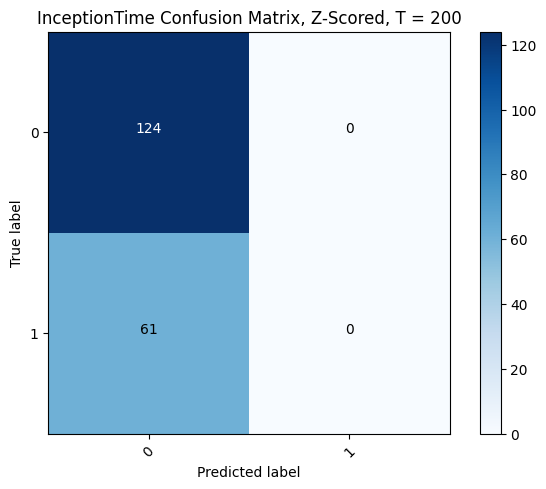

In [ ]:
plot_confusion_matrix(confmat, [0, 1])